***IEEE 33 Test Grid***


<img src="IEEE_33_Test_Grid.png" width="1400">


***ADMM Algorithm Test***

In [1]:
pip install pypsa

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandapower

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pypower

Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib inline


***IEEE 33 Test Network***

In [6]:
import pypsa
import pandapower.networks as pn
from pandapower.converter.pypower import to_ppc

net = pn.case33bw()

out = to_ppc(net, calculate_voltage_angles=True, init="flat")

# handle different return signatures across pandapower versions
ppc = out[0] if isinstance(out, tuple) else out

n = pypsa.Network()
n.import_from_pypower_ppc(ppc)

if len(n.snapshots) == 0:
    n.set_snapshots([0])

print("Imported buses:", len(n.buses), "lines:", len(n.lines),
      "loads:", len(n.loads), "gens:", len(n.generators))


Imported buses: 33 lines: 32 loads: 32 gens: 1


In [7]:
n.pf()

INFO:pypsa.network.power_flow:Performing non-linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x7fe0fde9be90> for snapshots Index(['now'], dtype='object', name='snapshot')


{'n_iter': name      0
 snapshot   
 now       3,
 'error': name                 0
 snapshot              
 now       7.467510e-08,
 'converged': name         0
 snapshot      
 now       True}

***Partition IEEE-33 into k connected regions***

In [8]:
import networkx as nx
from collections import defaultdict

def build_graph_from_pypsa(n):
    G = nx.Graph()
    for b in n.buses.index.astype(str):
        G.add_node(b)

    # Lines
    for name, row in n.lines.iterrows():
        G.add_edge(str(row.bus0), str(row.bus1), etype="line", name=str(name))

    # Transformers (if any)
    if hasattr(n, "transformers") and len(n.transformers) > 0:
        for name, row in n.transformers.iterrows():
            G.add_edge(str(row.bus0), str(row.bus1), etype="transformer", name=str(name))

    return G

def pick_root_bus(n):
    # Try slack generator bus first
    if len(n.generators) > 0:
        # Some imports mark a slack generator by control="Slack"
        slack = n.generators[n.generators.get("control", "") == "Slack"]
        if len(slack) > 0:
            return str(slack.bus.iloc[0])
        # Otherwise just pick first generator bus (in IEEE-33 this is usually the substation)
        return str(n.generators.bus.iloc[0])

    # Fallback: smallest bus name
    return str(sorted(n.buses.index.astype(str))[0])

def partition_radial_connected(G, k, root=None):
    """
    Partition a (mostly) radial graph into k connected regions by BFS distance from root.
    Works very well for IEEE-33 feeders.
    """
    if root is None:
        root = sorted(G.nodes)[0]
    root = str(root)

    # distances from root
    dist = nx.single_source_shortest_path_length(G, root)

    # sort buses by distance (then name for determinism)
    ordered = sorted(G.nodes, key=lambda b: (dist.get(b, 10**9), b))

    # chunk sizes
    N = len(ordered)
    k = int(k)
    if k < 1 or k > N:
        raise ValueError(f"k must be in [1, {N}]")

    base = N // k
    rem = N % k

    # initial assignment by contiguous chunks in distance order
    region_map = {}
    start = 0
    for r in range(k):
        size = base + (1 if r < rem else 0)
        chunk = ordered[start:start+size]
        for b in chunk:
            region_map[b] = r
        start += size

    # Optional: ensure each region is connected (for radial feeders, it typically is already)
    # If not, we fix by moving disconnected components to neighboring regions.
    for r in range(k):
        nodes_r = [b for b, rr in region_map.items() if rr == r]
        if not nodes_r:
            continue
        sub = G.subgraph(nodes_r)
        if nx.is_connected(sub):
            continue

        # Keep largest component in r, move others to a neighboring region
        comps = sorted(nx.connected_components(sub), key=len, reverse=True)
        keep = comps[0]
        for comp in comps[1:]:
            for b in comp:
                # choose neighbor region by looking at graph neighbors
                nbr_regions = [region_map[nbr] for nbr in G.neighbors(b) if nbr in region_map]
                if nbr_regions:
                    region_map[b] = max(set(nbr_regions), key=nbr_regions.count)
                else:
                    # fallback: send to region 0
                    region_map[b] = 0

    return region_map

def compute_boundaries_and_ties(G, region_map):
    boundary_by_region = defaultdict(set)
    tie_edges = []

    for u, v, data in G.edges(data=True):
        ru, rv = region_map[u], region_map[v]
        if ru != rv:
            tie_edges.append((u, v, data))
            boundary_by_region[ru].add(u)
            boundary_by_region[ru].add(v)  # u is boundary in ru, v boundary in rv
            boundary_by_region[rv].add(u)
            boundary_by_region[rv].add(v)

    # clean boundary sets: boundary bus in region r means bus is in r and has neighbor outside r
    cleaned = {}
    for r in set(region_map.values()):
        cleaned[r] = sorted([b for b in boundary_by_region[r] if region_map[b] == r])

    return cleaned, tie_edges


***Run it on the imported IEEE-33 Test Network***

In [9]:

G = build_graph_from_pypsa(n)
root = pick_root_bus(n)          # usually substation/slack bus
k = 3                            # Splitted into n regions 

region_map = partition_radial_connected(G, k=k, root=root)
boundary_by_region, tie_edges = compute_boundaries_and_ties(G, region_map)

print("Root bus:", root)
print("Regions:", sorted(set(region_map.values())))
for r in sorted(boundary_by_region):
    print(f"Region {r}: buses={sum(1 for b in region_map if region_map[b]==r)}, "
          f"boundary_buses={len(boundary_by_region[r])}")

print("Number of tie edges (cuts):", len(tie_edges))
for (u, v, data) in tie_edges[:10]:
    print("Tie:", u, "<->", v, data.get("etype"), data.get("name"))


Root bus: 0
Regions: [0, 1, 2]
Region 0: buses=12, boundary_buses=1
Region 1: buses=11, boundary_buses=3
Region 2: buses=10, boundary_buses=2
Number of tie edges (cuts): 3
Tie: 4 <-> 5 line L4
Tie: 10 <-> 11 line L10
Tie: 29 <-> 30 line L29


***Visualisation of the splitted region***

In [10]:
import pandas as pd

def renumber_buses_1_to_33(n):
    # Make sure we work with strings
    bus_ids = [str(b) for b in n.buses.index]

    # Detect 0-based numbering: contains '0' and max looks like 32
    if "0" not in bus_ids:
        print("No bus '0' found. Skipping renumbering.")
        return n

    # Build mapping: old -> new (shift +1)
    mapping = {str(i): str(i+1) for i in range(0, 33)}  # 0..32 -> 1..33

    # Rename buses index
    n.buses.rename(index=mapping, inplace=True)

    # Update all components that reference buses
    def _map_col(df, col):
        if col in df.columns:
            df[col] = df[col].astype(str).map(lambda x: mapping.get(x, x))

    for comp in ["lines", "transformers", "loads", "generators", "stores", "storage_units",
                 "links", "shunt_impedances"]:
        if hasattr(n, comp):
            df = getattr(n, comp)
            if df is None or len(df) == 0:
                continue
            if comp in ["lines", "transformers"]:
                _map_col(df, "bus0")
                _map_col(df, "bus1")
            else:
                _map_col(df, "bus")

    print("Renumbered buses 0–32 to 1–33.")
    return n

n = renumber_buses_1_to_33(n)
print("Bus min/max:", min(map(int, n.buses.index)), max(map(int, n.buses.index)))


Renumbered buses 0–32 to 1–33.
Bus min/max: 1 33


In [11]:
bus_xy = {
    "1": (0,0),
    "2": (1,0), "3": (2,0), "4": (3,0), "5": (4,0), "6": (5,0),
    "7": (6,0), "8": (7,0), "9": (8,0), "10": (9,0), "11": (10,0),
    "12": (11,0), "13": (12,0), "14": (13,0), "15": (14,0),
    "16": (15,0), "17": (16,0), "18": (17,0),

    # lower branch
    "19": (1,-2), "20": (2,-2), "21": (3,-2), "22": (4,-2),

    # upper left branch
    "23": (2,2), "24": (3,2), "25": (4,2),

    # upper right branch
    "26": (5,2), "27": (6,2), "28": (7,2), "29": (8,2),
    "30": (9,2), "31": (10,2), "32": (11,2), "33": (12,2),
}

for b,(x,y) in bus_xy.items():
    if b in n.buses.index:
        n.buses.loc[b,"x"] = x
        n.buses.loc[b,"y"] = y


In [12]:
region_map = {}

# Region 0: trunk part 1–8
for b in range(1, 9):
    region_map[str(b)] = 0

# Region 1: trunk part 9–18
for b in range(9, 19):
    region_map[str(b)] = 1

# Region 2: lower branch 19–22
for b in range(19, 23):
    region_map[str(b)] = 2

# Region 3: upper branches 23–25 and 26–33
for b in range(23, 26):
    region_map[str(b)] = 3
for b in range(26, 34):
    region_map[str(b)] = 3


In [13]:
import networkx as nx
from collections import defaultdict

def build_G(n):
    G = nx.Graph()
    for b in n.buses.index:
        G.add_node(str(b))
    for _, row in n.lines.iterrows():
        G.add_edge(str(row.bus0), str(row.bus1), name=str(_))
    return G

def compute_ties(G, region_map):
    region_map = {str(k): v for k,v in region_map.items()}
    ties = []
    for u,v,data in G.edges(data=True):
        if region_map[u] != region_map[v]:
            ties.append((u,v,data))
    return ties

G = build_G(n)
tie_edges = compute_ties(G, region_map)

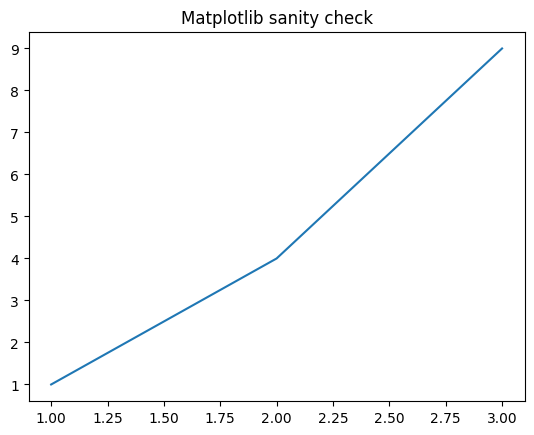

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot([1,2,3],[1,4,9])
plt.title("Matplotlib sanity check")
plt.show()


In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch
from IPython.display import display

def plot_partition_with_legend(n, region_map, tie_edges=None, title="IEEE-33 Partition"):
    region_map = {str(k): v for k, v in region_map.items()}

    # Build graph
    G = nx.Graph()
    for b in n.buses.index:
        G.add_node(str(b))
    for _, row in n.lines.iterrows():
        G.add_edge(str(row.bus0), str(row.bus1))

    # Use geographic coordinates if available
    if "x" in n.buses.columns and "y" in n.buses.columns:
        pos = {str(b):(float(n.buses.loc[str(b),"x"]),
                       float(n.buses.loc[str(b),"y"])) for b in G.nodes()}
    else:
        pos = nx.spring_layout(G, seed=2)

    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)

    # draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)

    # highlight tie edges (ADMM boundaries)
    if tie_edges:
        tie_uv = [(str(u), str(v)) for (u,v,_) in tie_edges]
        nx.draw_networkx_edges(G, pos, edgelist=tie_uv,
                               width=3, style="dashed", ax=ax)

    # node colours
    node_colors = [region_map.get(str(b),0) for b in G.nodes()]
    nodes = nx.draw_networkx_nodes(G, pos,
                                   node_color=node_colors,
                                   cmap=plt.cm.tab10,
                                   node_size=420,
                                   ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # -------- LEGEND --------
    regions = sorted(set(region_map.values()))
    cmap = plt.cm.tab10

    legend_elements = [
        Patch(facecolor=cmap(r), edgecolor='k', label=f"Region {r}")
        for r in regions
    ]

    ax.legend(handles=legend_elements,
              title="Partition",
              loc="right",
              bbox_to_anchor=(1.02, 1))

    ax.set_title(title)
    ax.axis("off")

    display(fig)
    plt.close(fig)


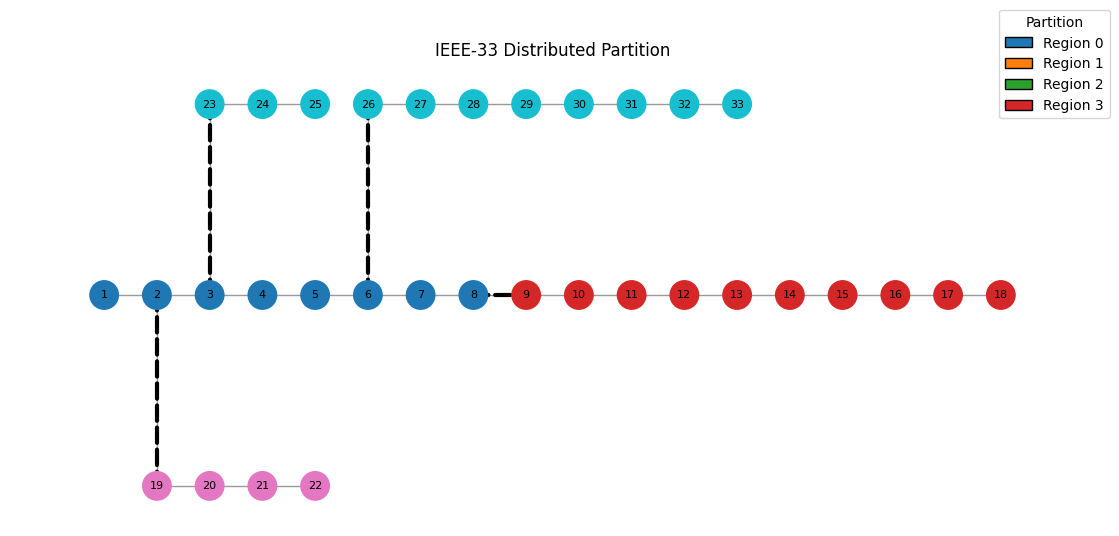

In [22]:
plot_partition_with_legend(n, region_map, tie_edges,
                           title="IEEE-33 Distributed Partition")
